In [110]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## - Classification -

### Santander XGBOOST

In [111]:
import sys
import os
from time import time
import numpy as np
import pandas as pd


import matplotlib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             accuracy_score,
                             classification_report,
                             roc_auc_score)
import matplotlib.pyplot as plt

In [112]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('./')

# set location of inputs for this module
moduleDir = './'
# set location of output files
outDir = os.path.join('./')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.05

<Figure size 1500x600 with 0 Axes>

## Load Data

In [113]:
train_df = pd.read_csv(os.path.join(inpDir, moduleDir, 'train.csv'))
test_df = pd.read_csv(os.path.join(inpDir, moduleDir, 'test.csv'))
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [114]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76


In [115]:
train_df['TARGET'].value_counts()

TARGET
0    73012
1     3008
Name: count, dtype: int64

In [116]:
class_names = train_df['TARGET'].unique()
class_names

array([0, 1], dtype=int64)

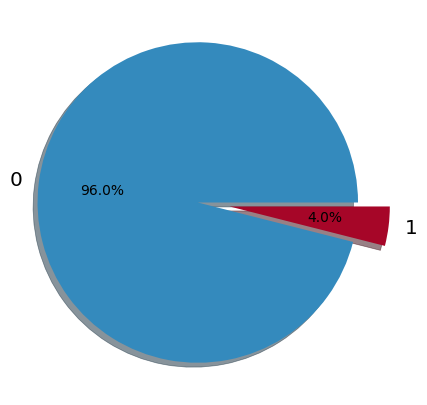

In [117]:
fig, ax = plt.subplots(figsize = (5,5))

explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. '1')

ax.pie(train_df['TARGET'].value_counts(), explode=explode, 
        labels=class_names, autopct='%1.1f%%',
        shadow=True, startangle=0)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

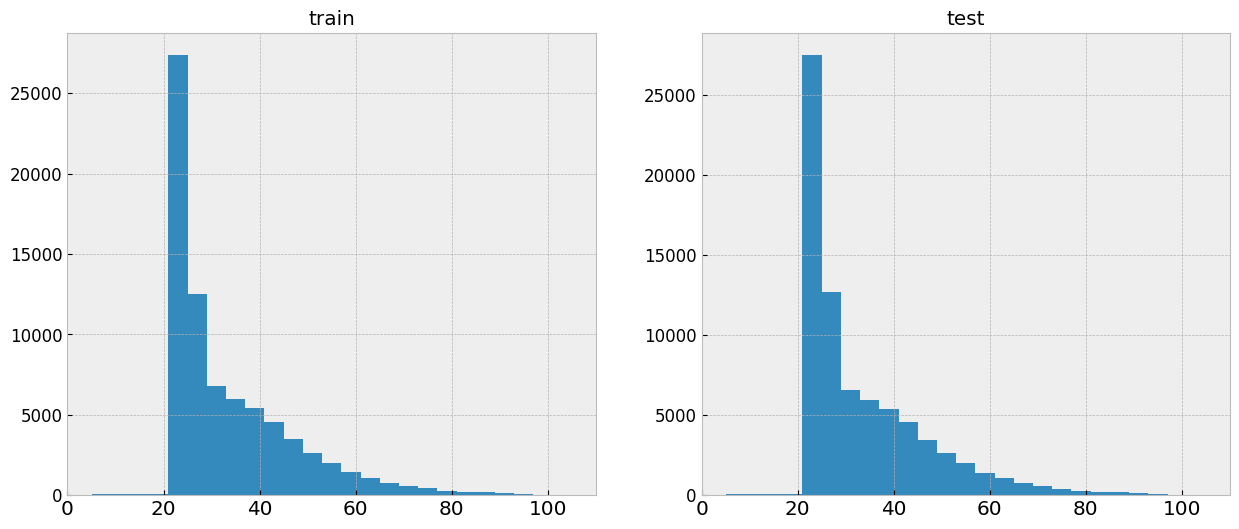

In [118]:
# var15 is AGE
fig, axes = plt.subplots(1,2)

ax = axes[0]

train_df['var15'].hist(bins=25, ax = ax)

ax.set_title('train');

ax = axes[1]

test_df['var15'].hist(bins=25, ax = ax)

ax.set_title('test');

In [119]:
# under 23 do not complain

print (len(train_df['TARGET'][train_df.var15<23]))

print (sum(train_df['TARGET'][train_df.var15<23]))

1212
0


### Combine train and test sets

In [120]:
## use for spltting up combined train+test data, recording predictions
labels = train_df['TARGET'].values

id_test = test_df['ID']
piv_train = train_df.shape[0]



# Creating a DataFrame with train+test data
df_all = pd.concat((train_df.drop(['TARGET'], axis=1),
                    test_df.copy()), axis=0, ignore_index=True)

# Removing id
df_all = df_all.drop(['ID'], axis=1)

print(df_all.isnull().sum() / df_all.shape[0])

df_all.head()

var3                       0.0
var15                      0.0
imp_ent_var16_ult1         0.0
imp_op_var39_comer_ult1    0.0
imp_op_var39_comer_ult3    0.0
                          ... 
saldo_medio_var44_hace2    0.0
saldo_medio_var44_hace3    0.0
saldo_medio_var44_ult1     0.0
saldo_medio_var44_ult3     0.0
var38                      0.0
Length: 369, dtype: float64


,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016


## Feature Engineering

In [121]:
# Create another column with count of zeros
df_all['n0'] = (df_all==0).sum(axis=1)
print (df_all.shape)

(151838, 370)


### Remove constant columns
One can also remove constant columns by length of unique values = 1 

In [122]:
# remove constant columns (std = 0)
drop_cols = []

for col in df_all.columns:
    
    if df_all[col].std() == 0:
        
        drop_cols.append(col)

df_all.drop(drop_cols, axis=1, inplace=True)

print (df_all.shape)

(151838, 336)


### Removal of dupe columns

In [123]:
# keep track of columns to remove
drop_cols = []

cols = df_all.columns

# loop thru cols to find equal values
for i in range(len(cols)-1):
    
    v = df_all[cols[i]].values
    
    for j in range(i+1,len(cols)):
        
        if np.array_equal(v,df_all[cols[j]].values):
            
            drop_cols.append(cols[j])


print (len(drop_cols))
print (drop_cols)

27
['ind_var29_0', 'ind_var29', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']


In [124]:
## Additional columns suggested by others

# extend the list of cols to remove
drop_cols += ['num_var13_medio', 'saldo_medio_var13_medio_ult1']

In [125]:
df_all.drop(drop_cols, axis=1, inplace=True)

print (df_all.shape)

(151838, 307)


### Limiting min/max values

In [126]:
# limit vars in test based on min and max vals of train
print('Setting min-max limits on test data...')

startTime = time()

for f in df_all.columns[:-1]:
    
    lim_min = np.min(train_df[f])
    
    mask = df_all[f] < lim_min
    
    df_all.loc[mask, f] = lim_min

    lim_max = np.max(train_df[f])
    
    mask = df_all[f] > lim_max
    
    df_all.loc[mask, f] = lim_max
    
    #print (f, ': min=', lim_min, ', max=', lim_max)

print (time() - startTime)

Setting min-max limits on test data...
0.6332378387451172


### Log Transform

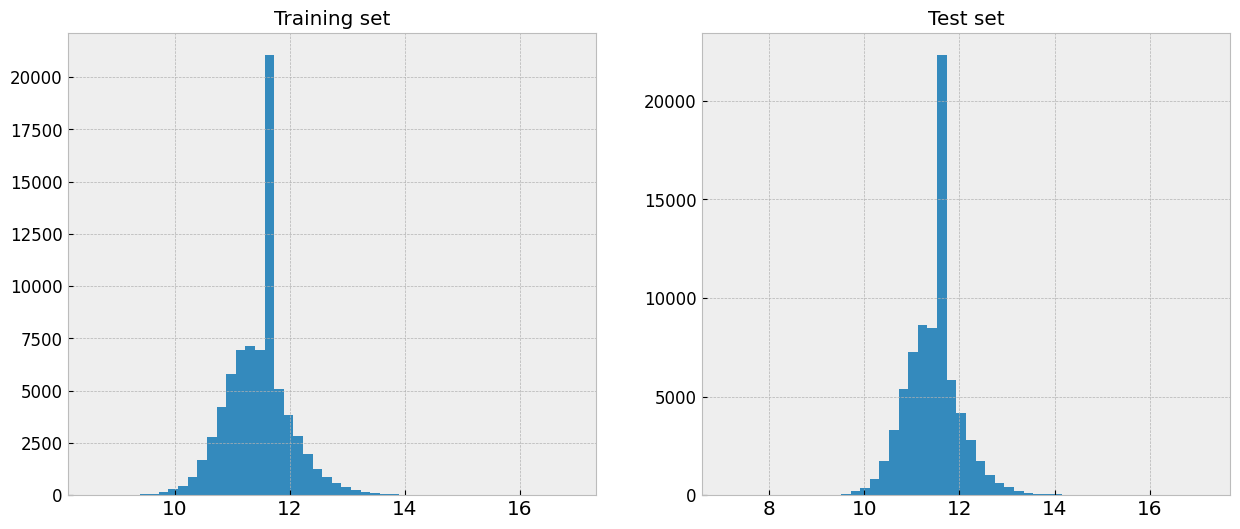

In [127]:
# Look at the data

fig, axes = plt.subplots(1,2)

axes[0].hist(np.log(train_df['var38']), bins=50)

axes[0].set_title('Training set')

axes[1].hist(np.log(test_df['var38']), bins=50)

axes[1].set_title('Test set');

In [128]:
# log transform 'var38'
df_all['var38'] = np.log(df_all['var38'])

### Train, test and validation sets

In [129]:
vals = df_all.copy()

fea_train_df = vals[:piv_train]
fea_test_df = vals[piv_train:]
y = labels

In [130]:
from sklearn.model_selection import train_test_split

## split into train and validation
## use X,y for full training data
X_train, X_valid, y_train, y_valid = train_test_split(fea_train_df, y, test_size=TEST_SIZE,
                                                      stratify=y, random_state=RANDOM_STATE)

print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

(72219, 307)
(72219,)
(3801, 307)
(3801,)


In [131]:
X_train

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,n0
20213,2,30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.612617,331
61688,2,24,0.0,24.21,146.70,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.079375,318
55660,2,24,90.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.672584,320
41147,2,23,0.0,304.56,307.53,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.234035,309
70592,2,46,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.672584,355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41253,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.274727,355
59073,2,31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.259215,337
33185,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.979526,355
66169,2,26,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.672584,337


In [132]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

X_test = sc.transform(fea_test_df)

## Training

In [133]:
from xgboost.sklearn import XGBClassifier


# set the validation set for xgb training
eval_set = [(X_train,y_train), (X_valid,y_valid)]

# try using... eval_metric: mlogloss, merror, ndcg@n-, logloss, auc
clf = XGBClassifier(eval_metric='logloss')


In [134]:
clf.fit(X_train, y_train, 
        eval_set=eval_set, 
        early_stopping_rounds=100)

c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.47298	validation_1-logloss:0.47310
[1]	validation_0-logloss:0.35253	validation_1-logloss:0.35309
[2]	validation_0-logloss:0.27820	validation_1-logloss:0.27870
[3]	validation_0-logloss:0.23000	validation_1-logloss:0.23063
[4]	validation_0-logloss:0.19772	validation_1-logloss:0.19817
[5]	validation_0-logloss:0.17572	validation_1-logloss:0.17652
[6]	validation_0-logloss:0.16069	validation_1-logloss:0.16194
[7]	validation_0-logloss:0.15004	validation_1-logloss:0.15200
[8]	validation_0-logloss:0.14266	validation_1-logloss:0.14494
[9]	validation_0-logloss:0.13754	validation_1-logloss:0.14036
[10]	validation_0-logloss:0.13384	validation_1-logloss:0.13716
[11]	validation_0-logloss:0.13118	validation_1-logloss:0.13474
[12]	validation_0-logloss:0.12899	validation_1-logloss:0.13278
[13]	validation_0-logloss:0.12746	validation_1-logloss:0.13181
[14]	validation_0-logloss:0.12629	validation_1-logloss:0.13138
[15]	validation_0-logloss:0.12513	validation_1-logloss:0.13064
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [135]:
y_pred = clf.predict(X_valid)

print(f'Accuracy : {accuracy_score(y_valid, y_pred):.4f}')

print(f'Precision: {precision_score(y_valid, y_pred, average="macro"):.4f}')

print(f'Recall   : {recall_score(y_valid, y_pred, average="macro"):.4f}')

Accuracy : 0.9608
Precision: 0.8138
Recall   : 0.5065


In [136]:
print(classification_report(y_valid, clf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3651
           1       0.67      0.01      0.03       150

    accuracy                           0.96      3801
   macro avg       0.81      0.51      0.50      3801
weighted avg       0.95      0.96      0.94      3801



In [137]:
## xgb, predict probabilities
y_proba = clf.predict_proba(X_valid)
print (roc_auc_score(y_valid, y_proba[:,1]))

0.8548835935360176


In [138]:
### Try adjusting output of some of the parameters to zero...

# remember features that predict 0
'''zero_feats = [('saldo_medio_var5_hace2', 160000), 
              ('saldo_var33', 0),
              ('var38', 3988596),
              ('var21', 7500),
              ('num_var30', 9),
              ('num_var13_0', 6),
              ('num_var33_0', 0),
              ('imp_ent_var16_ult1', 51003),
              ('imp_op_var39_comer_ult3', 13184),
              ('saldo_medio_var5_ult3', 108251),
             ]
for x,y in zero_feats:
    print (x, train[(train[x] > y) & (train.TARGET==1)].shape)
'''


"zero_feats = [('saldo_medio_var5_hace2', 160000), \n              ('saldo_var33', 0),\n              ('var38', 3988596),\n              ('var21', 7500),\n              ('num_var30', 9),\n              ('num_var13_0', 6),\n              ('num_var33_0', 0),\n              ('imp_ent_var16_ult1', 51003),\n              ('imp_op_var39_comer_ult3', 13184),\n              ('saldo_medio_var5_ult3', 108251),\n             ]\nfor x,y in zero_feats:\n    print (x, train[(train[x] > y) & (train.TARGET==1)].shape)\n"